# Bayesian Lasso

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

#### Example 1

We simulated n = 20 data set to fit models and n = 200 data set
to compare prediction errors of proposed models with eight predictors. We let
$β = (3, 1.5, 0, 0, 2, 0, 0, 0)′$ and $σ = 3$. The pairwise correlation between $x_i$ and $x_j$
was set to be $corr(i, j) = 0.5^{|i−j|}$

In [3]:
# Parameters
n_train = 20  # Number of training samples
n_test = 200  # Number of testing samples
p = 8         # Number of predictors
beta = np.array([3, 1.5, 0, 0, 2, 0, 0, 0])  # True regression coefficients
sigma = 3     # Standard deviation of noise
corr_decay = 0.5

# Create covariance matrix based on corr(i, j) = 0.5^|i-j|
cov_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Generate training predictors and noise
X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_train)
epsilon_train = np.random.normal(loc=0, scale=1, size=n_train)

# Generate training response (y)
y_train = X_train @ beta + sigma * epsilon_train

# Generate testing predictors and noise
X_test = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_test)
epsilon_test = np.random.normal(loc=0, scale=1, size=n_test)

# Generate testing response (y)
y_test = X_test @ beta + sigma * epsilon_test

# Output data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (20, 8) (20,)
Testing data shape: (200, 8) (200,)


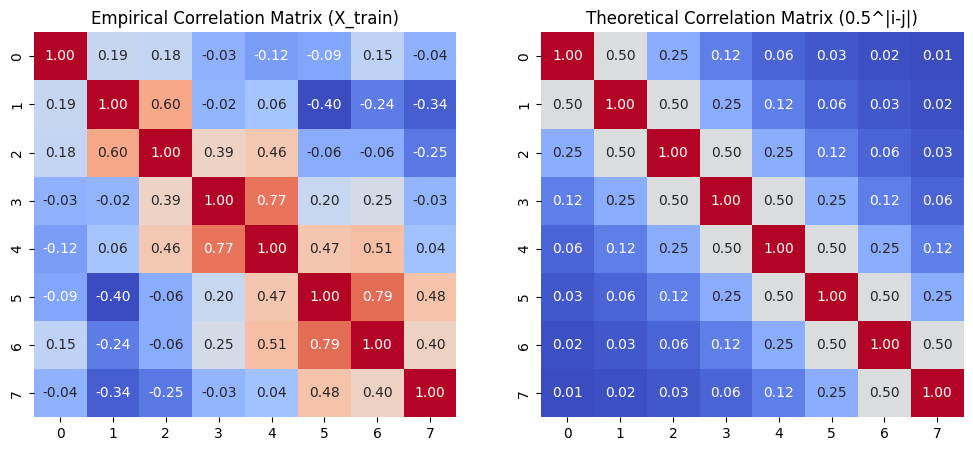

In [10]:
# Calculate empirical correlation matrix
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Calculate theoretical correlation matrix
p = X_train.shape[1]
theoretical_corr_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0], cbar=False)
axes[0].set_title("Empirical Correlation Matrix (X_train)")
sns.heatmap(theoretical_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], cbar=False)
axes[1].set_title("Theoretical Correlation Matrix (0.5^|i-j|)")

# plt.tight_layout()
plt.show()

In [13]:
# Simple linear regression model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.intercept_)
print(lr.coef_)

-0.8259204158546838
[ 2.986779    1.20344997  0.02074153 -0.18645247  3.51505681 -1.3358508
 -0.02386152  0.69790228]


##### Frequentist Lasso

In [29]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Define parameter grid for alpha (regularization parameter)
param_grid = {'alpha': [0.01, 0.1, 0.5, 0.8, 0.9, 1, 1.1, 2, 5, 10]}

# Perform Grid Search with Cross-Validation
grid = GridSearchCV(Lasso(fit_intercept=True), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Retrieve the best alpha and corresponding model
best_alpha = grid.best_params_['alpha']
best_model = grid.best_estimator_

# Predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluation
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

# Print the results
print("Frequentist Lasso Results with Hyperparameter Tuning:")
print(f"Best alpha: {best_alpha}")
print(f"Train MSE: {mse_train:.3f}")
print(f"Test MSE: {mse_test:.3f}")
print("Best Coefficients:", best_model.coef_)

Frequentist Lasso Results with Hyperparameter Tuning:
Best alpha: 0.9
Train MSE: 14.306
Test MSE: 25.144
Best Coefficients: [ 0.          0.          0.71052309  0.          1.49220298 -0.
  0.          0.        ]


In [25]:
for i, column in enumerate(range(X_train.shape[1])):
    print(f"Predictor {i+1} correlation with y_train: {np.corrcoef(X_train[:, column], y_train)[0, 1]:.2f}")

Predictor 1 correlation with y_train: 0.27
Predictor 2 correlation with y_train: 0.35
Predictor 3 correlation with y_train: 0.48
Predictor 4 correlation with y_train: 0.47
Predictor 5 correlation with y_train: 0.59
Predictor 6 correlation with y_train: 0.07
Predictor 7 correlation with y_train: 0.24
Predictor 8 correlation with y_train: -0.03


In [27]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=1, l1_ratio=0.7)
elastic_net.fit(X_train, y_train)
print("Elastic Net Coefficients:", elastic_net.coef_)

Elastic Net Coefficients: [ 0.          0.13529216  0.68759295  0.31993715  1.09398062 -0.
  0.          0.        ]


##### Bayesian Lasso

(Using NUTS and not Gibbs sampling)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, tau, beta, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2300 seconds.
There were 531 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]    0.688  1.122    -0.623      3.393      0.070    0.049     349.0   
beta[1]    0.485  0.767    -0.562      2.283      0.032    0.022     725.0   
beta[2]    0.399  0.593    -0.495      1.786      0.025    0.018     437.0   
beta[3]    0.321  0.579    -0.542      1.760      0.028    0.020     541.0   
beta[4]    1.360  1.124    -0.189      3.515      0.074    0.052     219.0   
beta[5]   -0.175  0.599    -1.565      0.933      0.019    0.014    1235.0   
beta[6]    0.136  0.676    -1.176      1.784      0.033    0.024     557.0   
beta[7]    0.059  0.420    -0.787      1.068      0.014    0.010     571.0   
intercept -0.172  0.787    -1.674      1.415      0.024    0.017    1118.0   

           ess_tail  r_hat  
beta[0]       451.0   1.01  
beta[1]      1276.0   1.00  
beta[2]      1230.0   1.01  
beta[3]      1172.0   1.00  
beta[4]      1513.0   1.01  
beta[5]      1120.0   1.02  
beta[6]       44

KeyError: 'y'

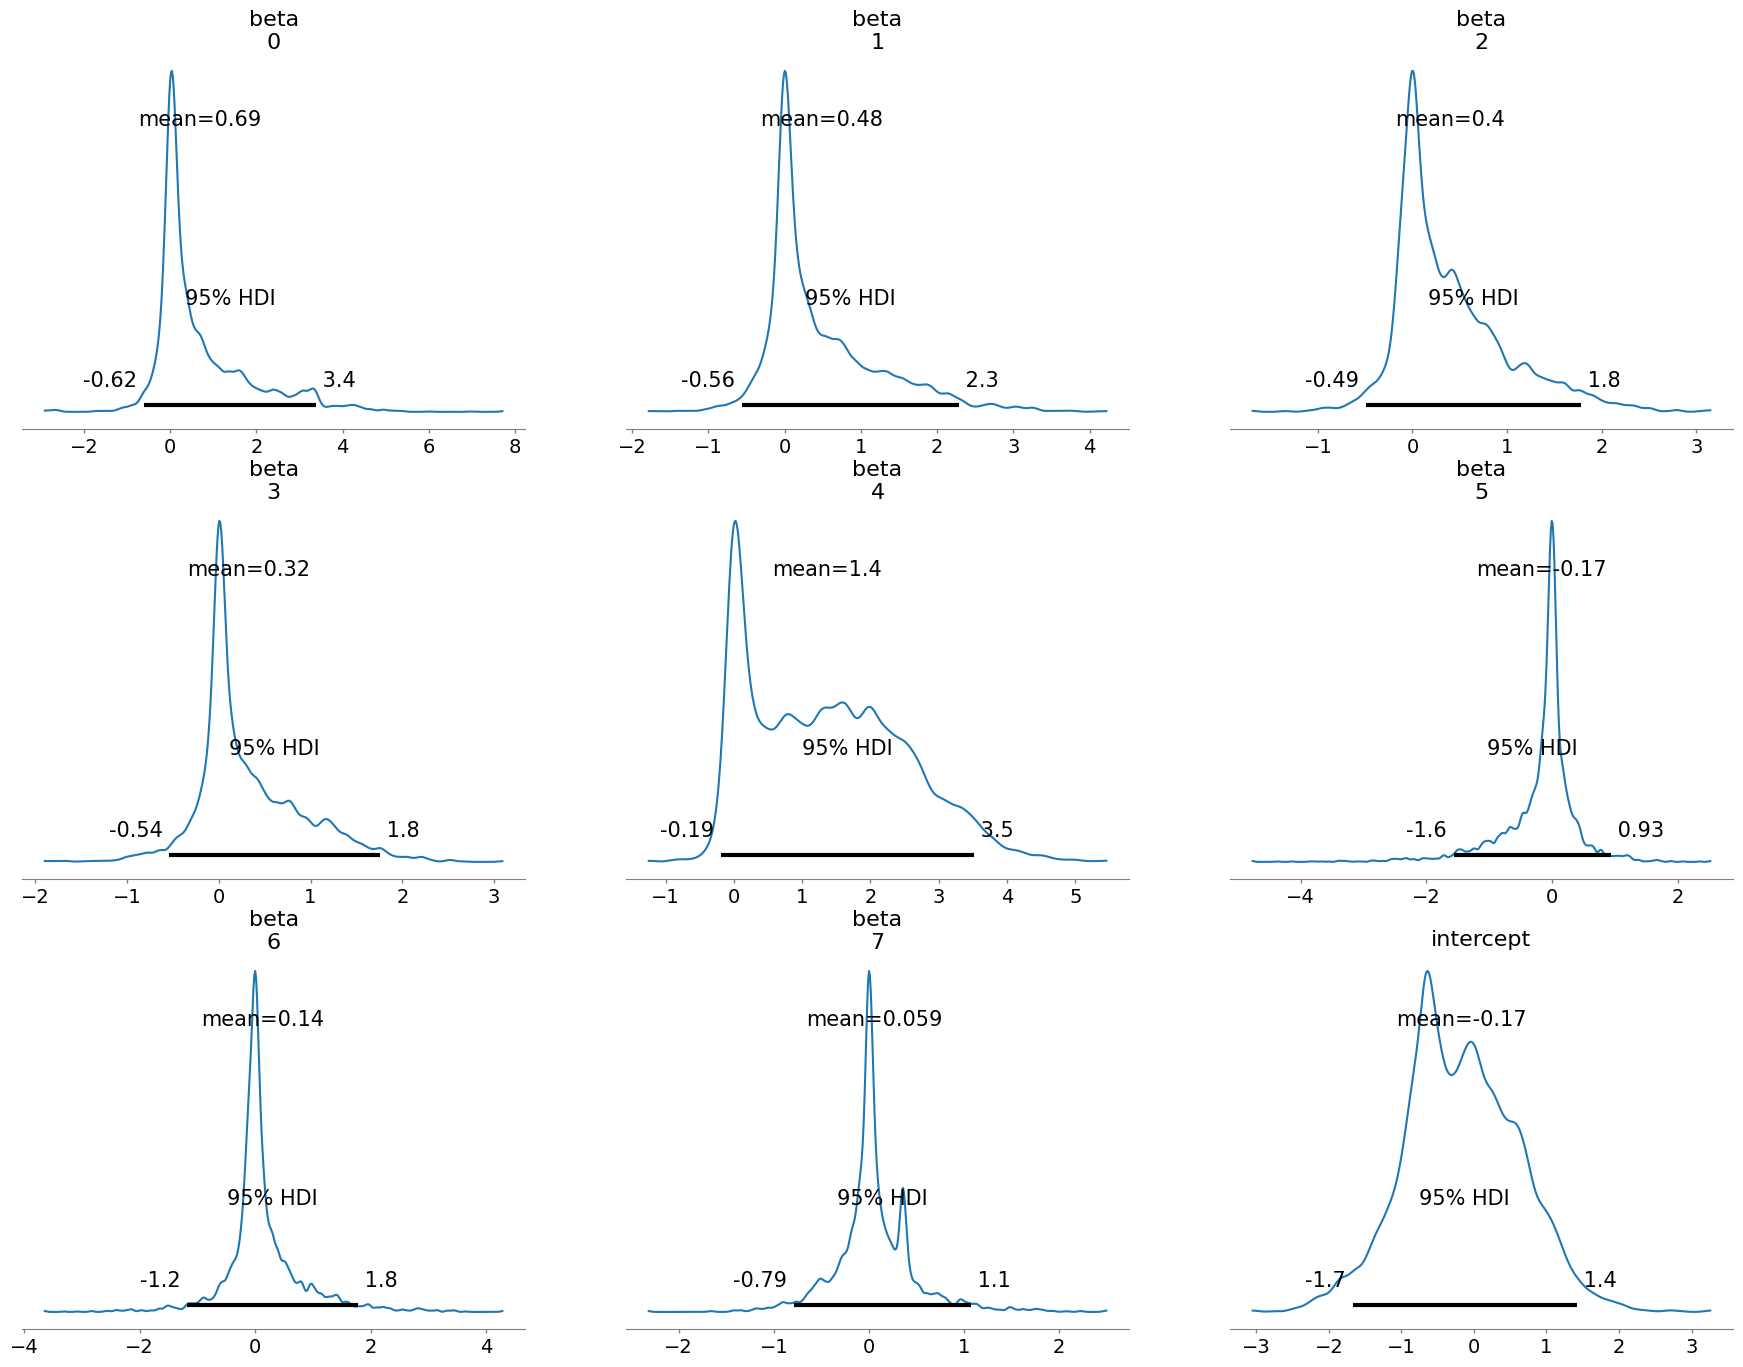

In [31]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Inference
    trace = pm.sample(1000, tune=1000, target_accept=0.9,  return_inferencedata=True, progressbar=True)

# Posterior summaries
pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)

summary = az.summary(trace, var_names=["beta", "intercept"], hdi_prob=0.95)
display(summary)

In [51]:
# Posterior Predictions
with bayesian_lasso:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_predictive_data = posterior_predictive['posterior_predictive']
print("Available keys inside posterior_predictive:", list(posterior_predictive_data.keys()))

# Extract the predictions
y_pred_samples = posterior_predictive_data['y'].values

# Compute posterior mean of y for each observation (across all chains and draws)
y_pred_mean = y_pred_samples.mean(axis=(0, 1))  # Averaging over chains (axis=0) and draws (axis=1)

# Extract observed y values
y_obs = posterior_predictive['observed_data']['y'].values

# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(y_obs, y_pred_mean)
print(f"Mean Squared Error (MSE): {mse:.3f}")

Available keys inside posterior_predictive: ['y', 'beta', 'intercept']
Mean Squared Error (MSE): 22.506


In [59]:
# Retrieve the posterior means for the coefficients
beta_post_mean = trace["beta"].mean(axis=0)
intercept_post_mean = trace["intercept"].mean()
print("Bayesian Lasso Results:")
print("Posterior Means for Coefficients:", beta_post_mean)
print("Posterior Mean for Intercept:", intercept_post_mean)

KeyError: 'beta'